In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import sklearn
%matplotlib inline
data_path = '/Users/dirlt/.kaggle/competitions/bike-sharing-demand/'

# Load Data

In [102]:
def extend_fields(df):
    df = df.copy()
    dt = df['datetime']
    dt2 = pd.to_datetime(dt)
    df['dt_day'] = dt2.apply(lambda x: x.day)
    df['dt_weekday'] = dt2.apply(lambda x: x.weekday())
    df['dt_month'] = dt2.apply(lambda x: x.month)
    df['dt_hour'] = dt2.apply(lambda x: x.hour)
    df['dt_year'] = dt2.apply(lambda x: x.year)
    df['dt_day2'] = dt2.apply(lambda x: '{}-{}-{}'.format(x.year, x.month, x.day))
    x = df
    x['temp'] = np.round(x['temp']).astype(int)
    x['atemp'] = np.round(x['atemp']).astype(int)
    x['humidity'] = np.round(x['humidity']).astype(int)
    x['windspeed'] = np.round(x['windspeed']).astype(int)
    tmp = pd.get_dummies(x['season'], prefix = 'season')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['weather'], prefix = 'weather')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_weekday'], prefix = 'weekday')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_month'], prefix = 'month')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_hour'], prefix = 'hour')
    x = x.join(tmp)
    tmp = pd.get_dummies(x['dt_year'], prefix = 'year')
    x = x.join(tmp)
    return x

In [103]:
ogn_df = pd.read_csv(data_path + 'train.csv')
df = extend_fields(ogn_df)

In [104]:
def group_plot(group_fields, value_fields = ['casual', 'registered']):
    df.groupby(group_fields)[value_fields].sum().plot(kind = 'bar', figsize = (10, 6))

# count 出现异常值

使用boxplot和distplot来观察分布情况

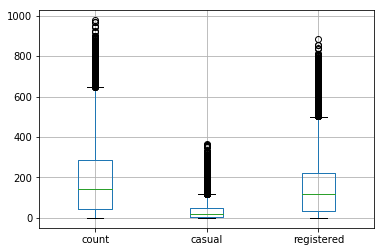

In [105]:
df.boxplot(['count', 'casual', 'registered'])

In [106]:
def _smooth_count(x, field):
    x2 = x.groupby('dt_day2').apply(lambda x: pd.Series.rolling(x[field], window = 3, center=True).mean())
    x2.index = x.index
    x2[x2.isnull()] = x.loc[x2.isnull(), field]
    x[field + "_2"] = np.round(x2).astype(np.int)
    return x

def smooth_count(x):
    _smooth_count(x, 'casual')
    _smooth_count(x, 'registered')
    x['count_2'] = x['casual_2'] + x['registered_2']
    return x
    
def filter_count_outlier(x, test = False):
    if test: return x    
#     x = x[x['count'] <= 600]
#     x = x[x['registered'] <= 400]
#     x = x[x['casual'] <= 100]
    return x
df = filter_count_outlier(df)

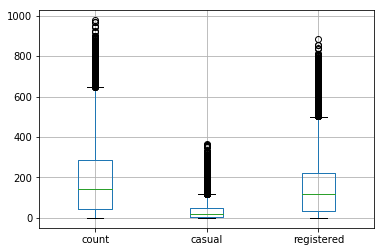

In [107]:
df.boxplot(['count', 'casual', 'registered'])

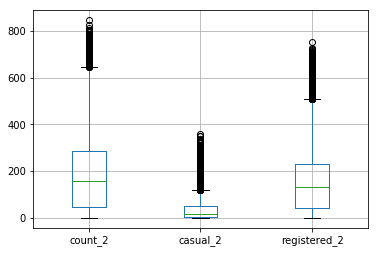

In [109]:
tmp_df = df.copy()
tmp_df = smooth_count(tmp_df)
tmp_df.boxplot(['count_2', 'casual_2', 'registered_2'])

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


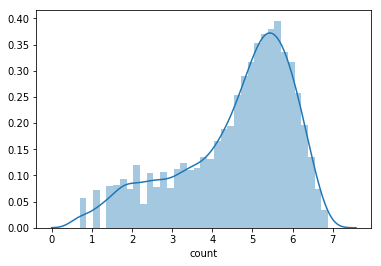

In [110]:
sns.distplot(np.log1p(df['count']))

# 体感温度的修正

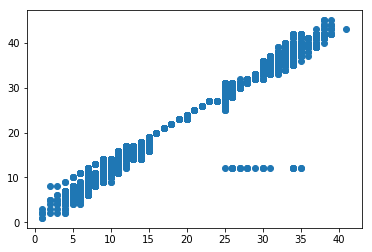

In [111]:
plt.scatter(df['temp'], df['atemp'])

In [112]:
def fix_atemp(x):
    atemp_outliner = (x['temp'] / x['atemp'] > 2.0)
    x.loc[atemp_outliner, 'atemp'] = x.loc[atemp_outliner, 'temp']
    x['atemp'] = x['atemp'].astype(int)
    return x
df = fix_atemp(df)

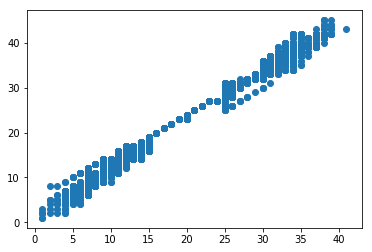

In [113]:
plt.scatter(df['temp'], df['atemp'])

# hour分布情况

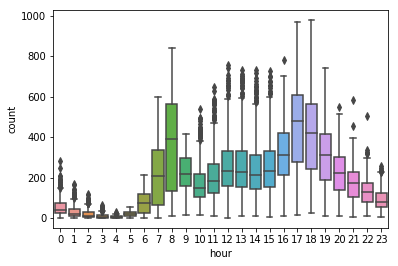

In [114]:
df['hour'] = df['dt_hour'].astype('category')
sns.boxplot(data = df, x = 'hour', y = 'count')

casual: 如果左移4个单位的话可以看到非常对称

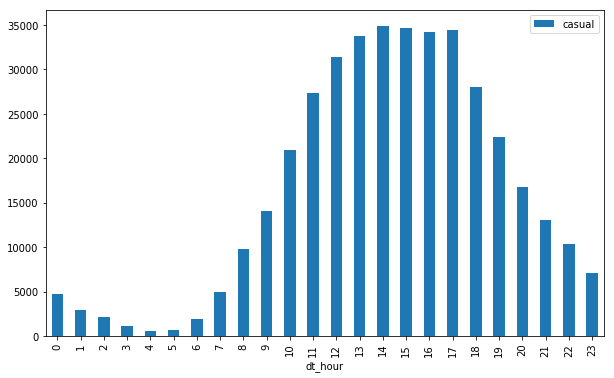

In [115]:
group_plot('dt_hour', value_fields=['casual'])

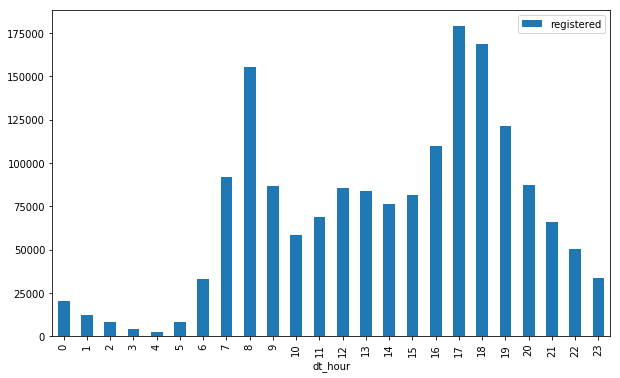

In [116]:
group_plot('dt_hour', ['registered'])

# winspeed异常

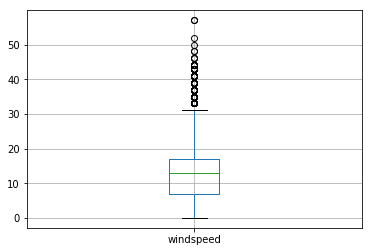

In [117]:
df.boxplot('windspeed')

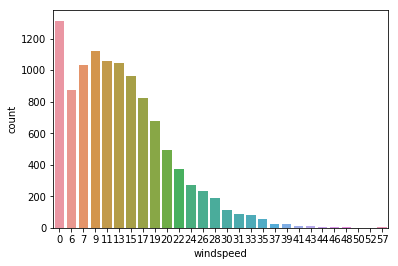

In [118]:
sns.countplot(df['windspeed'])

In [119]:
def mark_windspeed(x):
    x['windspeed_0'] = 0
    x.loc[(x['windspeed'] == 0),'windspeed_0'] = 1
    return x
df = mark_windspeed(df)

# humidity, temp, windspeed关系

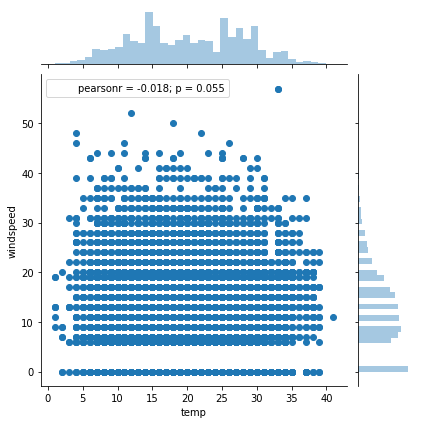

In [120]:
sns.jointplot('temp', 'windspeed', data = df)

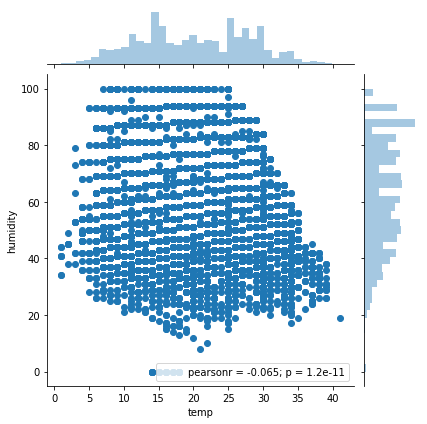

In [121]:
sns.jointplot('temp', 'humidity', data = df)

# 输出features

In [125]:
def select_features(df, test = False):
    columns = ['holiday', 'workingday',  'casual', 'registered',
               'count', 'dt_month', 'dt_day', 'dt_hour',
               'temp', 'humidity', 'windspeed', 'atemp',
               'season', 'dt_weekday', 'weather', 'dt_year', 'windspeed_0']
    columns.extend(['season_{}'.format(x) for x in range(1,5)])
    columns.extend(['weather_{}'.format(x) for x in range(1,5)])
    columns.extend(['weekday_{}'.format(x) for x in range(0, 7)])
    columns.extend(['month_{}'.format(x) for x in range(1, 13)])
    columns.extend(['year_{}'.format(x) for x in range(2011, 2013)])
    columns.extend(['hour_{}'.format(x) for x in range(0, 24)])

    if test:
        columns.remove('count')
        columns.remove('casual')
        columns.remove('registered')
        columns.insert(0, 'datetime')
    
    if not test:
        # 对casual以及registered做平滑处理
        if 'count_2' in df.columns:
            df['count'] = df['count_2']
            df['casual'] = df['casual_2']
            df['registered'] = df['registered_2']
    return df[columns]

In [123]:
train_df = pd.read_csv(data_path + 'train.csv')
train_df = extend_fields(train_df)
train_df = filter_count_outlier(train_df)
train_df = mark_windspeed(train_df)
output_df = select_features(train_df)
output_df.to_csv('mytrain.csv', index=False)

In [124]:
test_df = pd.read_csv(data_path + 'test.csv')
test_df = extend_fields(test_df)
test_df = mark_windspeed(test_df)
test_output_df = select_features(test_df, test=True)
test_output_df.to_csv('mytest.csv', index = False)